In [30]:
from google.colab import drive
drive.mount('/content/drive')
import xml.etree.ElementTree as ET
import os
import shutil
import yaml
import json

from sklearn.model_selection import train_test_split



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
def extract_data_from_xml(path):
  tree = ET.parse(path)
  root = tree.getroot()

  image_paths = []
  image_sizes = []
  image_labels= []
  bounding_boxes= []

  for image in root:
    bbs_of_image = []
    labels_of_image = []

    for bbs in image.findall('taggedRectangles'):
      for bb in bbs:
        #check non alphabet or non_number
        if not bb[0].text.isalnum():
          continue
        if "é" in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
          continue
        bbs_of_image.append([
          float(bb.attrib['x']),
          float(bb.attrib['y']),
          float(bb.attrib['width']),
          float(bb.attrib['height'])
      ])
      labels_of_image.append(bb[0].text.lower())

    # break;
    # print("hello")
    #store
    image_paths.append(image[0].text)
    image_sizes.append([
      int(image[1].attrib['x']),
      int(image[1].attrib['y'])
    ])
    bounding_boxes.append(bbs_of_image)
    image_labels.append(labels_of_image)
    # break

  return image_paths, image_sizes, image_labels, bounding_boxes



In [14]:
dataset_dir = "drive/MyDrive/Study/AIO/Scene Text Recognition/SceneTrialTrain"
word_xml_path = os.path.join(dataset_dir,"words.xml")
image_path, image_size, image_label, image_bounding_boxes=extract_data_from_xml(word_xml_path)
# print(image_path)
# print(image_size)
# print(image_label)
print(image_bounding_boxes)

[[[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0], [184.0, 612.0, 622.0, 174.0], [863.0, 599.0, 446.0, 187.0], [72.0, 6.0, 95.0, 87.0], [247.0, 2.0, 197.0, 88.0], [792.0, 0.0, 115.0, 81.0], [200.0, 848.0, 228.0, 139.0], [473.0, 878.0, 165.0, 109.0], [684.0, 878.0, 71.0, 106.0], [806.0, 844.0, 218.0, 141.0]], [[432.0, 635.0, 847.0, 172.0]], [[656.0, 222.0, 502.0, 81.0], [626.0, 253.0, 540.0, 31.0], [709.0, 307.0, 409.0, 69.0], [791.0, 368.0, 265.0, 73.0], [1152.0, 953.0, 57.0, 19.0], [653.0, 1006.0, 63.0, 15.0], [1101.0, 974.0, 111.0, 14.0], [1065.0, 1000.0, 70.0, 16.0], [1138.0, 1000.0, 74.0, 15.0], [1067.0, 1025.0, 145.0, 18.0]], [[682.0, 754.0, 64.0, 43.0], [796.0, 759.0, 61.0, 40.0], [573.0, 541.0, 138.0, 52.0], [743.0, 532.0, 350.0, 61.0], [1141.0, 528.0, 64.0, 75.0], [642.0, 635.0, 103.0, 52.0], [788.0, 625.0, 363.0, 59.0], [730.0, 243.0, 374.0, 77.0], [577.0, 334.0, 644.0, 102.0], [611.0, 458.0, 99.0, 26.0], [714.0, 455.0, 85.0, 27.0], [810.0, 451.0, 54.0, 26.0], [871.

In [15]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


2. Nomolize bounding box

In [16]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    yolov8_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size
        yolov8_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Tính toán tọa độ bounding box chuẩn hóa
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Vì chúng ta chỉ có một lớp, nên class_id được gán là 0
            class_id = 0

            # Chuyển đổi sang định dạng YOLOv8
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data


In [17]:
class_labels ='Test'
yolov8_data = convert_to_yolov8_format(image_path,image_size,image_bounding_boxes)

3. Train, Val, Test split

In [18]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(yolov8_data, test_size=val_size, random_state=seed, shuffle=is_shuffle)

test_data, val_data = train_test_split(yolov8_data, test_size=test_size, random_state=seed, shuffle=is_shuffle)


4. Save Data

In [19]:
def save_data(data, src_img_dir, save_dir):
  os.makedirs(save_dir, exist_ok=True)

  os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
  os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

  for image_path, yolov8_labels in data:
    shutil.copy(
        os.path.join(src_img_dir, image_path),
        os.path.join(save_dir, "images")
    )

    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    with open(os.path.join(save_dir,'labels', f"{image_name}.txt"), 'w') as f:
      for label in yolov8_labels:
        f.write(f"{label}\n")

In [20]:
save_yolov8_data_dir = "drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data"
os.makedirs(save_yolov8_data_dir, exist_ok=True)


save_train_dir = os.path.join(save_yolov8_data_dir, "train")
save_val_dir = os.path.join(save_yolov8_data_dir,"val")
save_test_dir = os.path.join(save_yolov8_data_dir,"test")

save_data(train_data,dataset_dir,save_train_dir)
save_data(val_data,dataset_dir,save_val_dir)
save_data(test_data,dataset_dir,save_test_dir)

5. Create yaml file.

In [21]:
data_yaml = {
    'path': '/content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data',
    'train': '/content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/train/images',
    'val': '/content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/val/images',
    'test': '/content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/test/images',
    'nc': 1,
    'names': ['class_labels']
}
yolo_yaml_path = os.path.join(save_yolov8_data_dir, 'data.yml')
with open(yolo_yaml_path, 'w') as f:
  yaml.dump(data_yaml, f,default_flow_style = False)


6. Training

In [22]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml').load('yolov8n.pt')

epochs = 200
imgsz = 1024

result = model.train(
    data = yolo_yaml_path,
    epochs = epochs,
    imgsz = imgsz,
    project = 'models',
    name = 'yolov8/detec/train'
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 126MB/s]


Transferred 355/355 items from pretrained weights
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/data.yml, epochs=200, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=train, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLOv8n summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mix

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.3 ms, read: 78.4±41.6 MB/s, size: 420.8 KB)


train: Scanning /content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 113.80it/s]


train: New cache created: /content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.9±0.6 ms, read: 55.0±35.5 MB/s, size: 243.6 KB)


val: Scanning /content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/val/labels... 32 images, 2 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 71.32it/s]

val: New cache created: /content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/val/labels.cache


Plotting labels to models/yolov8/detec/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to models/yolov8/detec/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      5.19G      1.714      3.332      1.584         37       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all         32        133    0.00844      0.609      0.283      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.14G      1.105      1.972      1.188         61       1024: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         32        133      0.552      0.594       0.51      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      6.17G      1.155      1.704      1.158         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         32        133      0.792      0.316       0.49      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.18G      1.119      1.583      1.153         67       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         32        133      0.655      0.511      0.564      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       6.2G      1.113      1.552      1.176         41       1024: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         32        133       0.56      0.459      0.498      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.22G      1.096      1.437      1.171         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         32        133      0.669      0.632      0.633      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      6.24G      1.079       1.37       1.14         49       1024: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         32        133      0.745      0.658      0.716      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.25G      1.128      1.382      1.149         54       1024: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         32        133      0.607      0.755      0.668      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.26G      1.137      1.309       1.15         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         32        133      0.732       0.74      0.757      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      6.29G      1.113      1.224      1.128        107       1024: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         32        133      0.679      0.668      0.717      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.31G      1.096      1.305      1.154         47       1024: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         32        133      0.578      0.707      0.654      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.32G      1.066      1.222      1.124         78       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         32        133      0.761      0.815      0.782      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      6.33G      1.051      1.118      1.104         68       1024: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        133      0.814      0.805      0.848      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.36G       1.11      1.127      1.132         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         32        133      0.847       0.75      0.839      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      6.38G      1.039      1.051      1.102         68       1024: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         32        133      0.771       0.88      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.39G      1.059      1.069      1.122         40       1024: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.863      0.835      0.888      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200       6.4G      1.031      1.014      1.091         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         32        133      0.782      0.834      0.848      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      6.43G      1.032      1.008      1.092         79       1024: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         32        133      0.809      0.892       0.86      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      6.44G      1.053      1.004      1.112         82       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         32        133      0.876      0.752       0.84      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.46G      1.055     0.9879      1.105         79       1024: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         32        133      0.798      0.802      0.829      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.47G      0.992      0.934      1.099         51       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         32        133      0.796      0.842      0.859      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      6.49G     0.9699     0.8971      1.063         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         32        133      0.929      0.827      0.908      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      6.51G     0.9511     0.8604      1.041         55       1024: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         32        133      0.856      0.896      0.904       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      6.53G      1.017     0.9138      1.077         61       1024: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        133      0.841      0.887      0.906      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      6.54G     0.9543     0.8628      1.056         67       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         32        133      0.888      0.887      0.912      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      6.56G     0.9799     0.8787      1.076         51       1024: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         32        133      0.876       0.88      0.916      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      6.58G     0.9609     0.8352      1.057         59       1024: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         32        133      0.808       0.85      0.884      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       6.6G     0.9404     0.8052      1.052         63       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         32        133      0.832      0.822      0.878      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      6.61G     0.9238     0.8307      1.054         72       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         32        133      0.806      0.872      0.877      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      6.63G     0.9307     0.8168      1.063         53       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         32        133      0.833      0.902      0.913      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      6.65G     0.8868     0.7875      1.035         49       1024: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         32        133      0.777      0.872      0.867      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.67G     0.9535     0.8275      1.079         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         32        133      0.823      0.871      0.891      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      6.67G     0.8948     0.7723      1.019         49       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         32        133      0.847      0.835      0.865      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       6.7G     0.9414     0.7651      1.034         80       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.905      0.857      0.916      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      6.72G     0.9089     0.7597      1.036         77       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         32        133      0.856      0.895      0.905      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.73G     0.9147      0.749      1.043         38       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         32        133      0.898      0.865      0.907      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.74G     0.9107     0.7544      1.041         47       1024: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32        133      0.833      0.898      0.893       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      6.77G     0.9052     0.7339      1.037         59       1024: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         32        133      0.888      0.832      0.896      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      6.79G     0.9168     0.7527      1.036         92       1024: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         32        133      0.869      0.798      0.857       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200       6.8G     0.9305     0.7531      1.035         83       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         32        133      0.826      0.865        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.81G     0.8749     0.7361      1.046         41       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         32        133      0.843      0.849      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      6.84G     0.9156     0.7386      1.038         54       1024: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         32        133      0.887       0.82      0.903      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.85G     0.8711     0.6918      1.032         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         32        133      0.916      0.835      0.902      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.87G     0.8705     0.6924      1.022         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         32        133      0.809      0.887      0.878      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      6.88G     0.8608     0.6647      1.016         31       1024: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32        133      0.809      0.859      0.871      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      6.91G     0.8852     0.7262      1.035         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         32        133      0.853      0.842      0.886       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      6.92G     0.8281     0.6757      1.017         69       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         32        133      0.857      0.872      0.897      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.94G     0.8413     0.6864      1.009         56       1024: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         32        133      0.882      0.846      0.862      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.95G     0.8174     0.6647      1.007         67       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         32        133      0.869       0.85      0.913      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      6.97G     0.8482     0.6594      1.008         63       1024: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         32        133      0.825      0.889      0.895      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      6.99G     0.8664      0.655      1.018         68       1024: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.858      0.887      0.919      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      7.01G     0.8327     0.6364     0.9855         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         32        133      0.871      0.865      0.918       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      7.02G     0.8206     0.6601     0.9975         59       1024: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         32        133      0.874      0.865      0.902      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      7.04G     0.8265     0.6389      1.002         36       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.803      0.887      0.908      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      7.06G     0.8041     0.6134     0.9918         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         32        133      0.845      0.932      0.925      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      7.08G     0.8477     0.6472     0.9853         67       1024: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         32        133      0.875      0.835      0.899      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      7.09G      0.845     0.6684      1.005         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         32        133      0.824      0.912      0.916      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      7.11G     0.8131     0.6355      1.011         90       1024: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         32        133      0.855      0.872      0.903      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      7.13G     0.8235     0.6303     0.9917         62       1024: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         32        133      0.881      0.835      0.899      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      7.15G     0.7922     0.6082     0.9691         41       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         32        133      0.905      0.865      0.923      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      7.15G     0.7944     0.5975     0.9829         53       1024: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         32        133      0.854       0.88      0.918      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      7.18G     0.8274     0.6257      1.009         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         32        133      0.889      0.846      0.895      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       7.2G     0.8286      0.616     0.9973         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.901      0.827      0.883      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      7.21G     0.8213     0.6217     0.9967         67       1024: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         32        133      0.843      0.895      0.914      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      7.22G     0.8061     0.6068     0.9961         30       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.888      0.893      0.918      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      7.25G     0.7629     0.5485     0.9681         44       1024: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         32        133       0.89      0.902      0.922       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      7.27G      0.758     0.5789     0.9751         48       1024: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         32        133      0.875      0.895      0.922      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      7.28G      0.775     0.5816     0.9765         63       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         32        133      0.869      0.902      0.904      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      7.29G     0.7763       0.59     0.9905         74       1024: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         32        133      0.875       0.84      0.879      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      7.32G     0.8078     0.5866     0.9801         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         32        133      0.893      0.877      0.907      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      7.33G     0.7622     0.5708     0.9628         85       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         32        133      0.832      0.932      0.888      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      7.35G     0.8067     0.6161     0.9807         73       1024: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         32        133      0.815      0.896      0.866      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      7.36G     0.7669     0.5877     0.9635         60       1024: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         32        133      0.912      0.895      0.912      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      5.08G     0.7703     0.5968     0.9796         43       1024: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         32        133      0.842      0.925      0.922      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      6.22G     0.7336     0.5579      0.963         41       1024: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         32        133      0.847      0.916        0.9      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.22G     0.7734     0.5687      0.978         40       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         32        133      0.849       0.89      0.881      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      6.22G     0.7624      0.567     0.9753         52       1024: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         32        133      0.894      0.887      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.22G     0.7837      0.591     0.9805         42       1024: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         32        133      0.891      0.924      0.922      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      6.22G     0.7464     0.5467     0.9731         69       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32        133      0.886      0.887      0.874      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.22G     0.7571     0.5594     0.9643         62       1024: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         32        133      0.845        0.9      0.888      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.22G     0.7488     0.5572     0.9566         47       1024: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         32        133      0.838      0.902      0.897      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      6.22G     0.7624      0.547     0.9645         69       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         32        133      0.884      0.902      0.895      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.22G     0.7617     0.5445      0.948         55       1024: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         32        133      0.895      0.925      0.916      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.22G     0.7716     0.5636     0.9614         92       1024: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         32        133      0.901      0.895       0.92      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.22G     0.7413     0.5381     0.9593        117       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         32        133      0.852      0.908      0.917      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      6.22G     0.7486     0.5499     0.9569         49       1024: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         32        133      0.887      0.917      0.905      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      6.22G     0.7567     0.5334     0.9577         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.878      0.924      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      6.22G     0.7395     0.5277     0.9754         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         32        133       0.88      0.895      0.891       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      6.22G     0.7402     0.5414      0.957         50       1024: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.876      0.902      0.902      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      6.25G     0.7447     0.5197     0.9459         80       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         32        133      0.914      0.875      0.893      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      6.26G     0.7364     0.5319     0.9529         83       1024: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         32        133      0.899       0.85      0.913      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      6.28G     0.7098     0.4996     0.9529        107       1024: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         32        133      0.901      0.895      0.913      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      6.29G     0.7059     0.5092     0.9377         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         32        133      0.855      0.928      0.901      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      6.31G     0.7086     0.5132     0.9517         67       1024: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         32        133       0.89      0.887       0.89      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      6.33G     0.7352     0.5468     0.9658         42       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         32        133      0.902      0.865      0.908      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      6.35G     0.7394     0.5374     0.9441         78       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         32        133       0.84       0.91      0.911      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.36G     0.7256     0.5264     0.9466         46       1024: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.861      0.872      0.898      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      6.38G     0.7529     0.5369     0.9573         43       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         32        133      0.879      0.878      0.899      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       6.4G      0.685     0.4896     0.9349         51       1024: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         32        133      0.904      0.827      0.884      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      6.42G     0.7074     0.4921     0.9518         63       1024: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         32        133      0.864      0.811      0.861      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      6.42G     0.6919     0.4907     0.9453         79       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         32        133       0.87      0.909      0.896      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      6.45G      0.726     0.5211     0.9459         69       1024: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         32        133      0.864      0.908      0.923      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      6.47G     0.6769     0.4943     0.9309         73       1024: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133        0.9      0.878      0.917      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      6.49G      0.681     0.4695     0.9432         51       1024: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         32        133      0.885      0.872      0.918      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      6.49G     0.7043     0.4798     0.9449         75       1024: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         32        133      0.886      0.902      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      6.52G     0.6887     0.5039     0.9471         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         32        133      0.913      0.857      0.896      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      6.54G     0.6386     0.4707     0.9268         47       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         32        133      0.893      0.865      0.904      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.55G     0.6734     0.4795     0.9374         50       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         32        133      0.885      0.872      0.912       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.56G     0.6809     0.4837     0.9421         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         32        133       0.89       0.91      0.914      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      6.59G     0.6718     0.4787     0.9272         71       1024: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         32        133      0.889       0.91      0.929      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      6.61G     0.6719     0.4703     0.9365         79       1024: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         32        133      0.923       0.91       0.94      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.62G      0.689     0.4766     0.9417         52       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         32        133      0.908      0.902      0.938      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      6.63G     0.6605     0.4654     0.9224         86       1024: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         32        133      0.866      0.932      0.923      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      6.66G     0.6568     0.4701     0.9407         45       1024: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.871      0.911      0.925      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      6.67G     0.6599     0.4658     0.9314         78       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         32        133      0.925      0.887      0.929      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.69G     0.6561     0.4661     0.9219         65       1024: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         32        133      0.905      0.936      0.934      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       6.7G     0.6685     0.4823     0.9298         49       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         32        133      0.921      0.882      0.933      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      6.72G     0.6751     0.4798     0.9216         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.905      0.925      0.945      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      6.74G     0.6642     0.4673     0.9319         92       1024: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         32        133      0.923        0.9      0.935      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      6.76G     0.6701     0.4611     0.9254         79       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         32        133      0.906      0.872      0.923      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      6.77G     0.6572     0.4659     0.9225         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         32        133      0.911      0.865      0.938      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      6.79G     0.6496     0.4741     0.9374         76       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         32        133        0.9      0.887      0.928      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      6.81G     0.6506     0.4657     0.9297         49       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         32        133      0.887       0.85      0.932      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.83G     0.6347     0.4498     0.9271         63       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         32        133      0.843      0.887      0.909      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      6.84G      0.639     0.4565      0.932         52       1024: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         32        133      0.872       0.88      0.903      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      6.86G     0.6618     0.4485     0.9304         58       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         32        133      0.862      0.902      0.906      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      6.88G     0.6617     0.4502     0.9296         72       1024: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         32        133       0.82      0.926      0.904      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200       6.9G      0.635      0.439     0.9314         60       1024: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         32        133      0.861       0.91      0.906       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200       6.9G     0.6303     0.4483     0.9182         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        133      0.922      0.884      0.922      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      6.93G     0.6192     0.4265     0.9258         83       1024: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         32        133      0.943      0.879      0.932      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      6.95G     0.6166     0.4303     0.9225         59       1024: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         32        133      0.885      0.917      0.931      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.97G     0.6322     0.4446     0.9339         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         32        133       0.91      0.917      0.916       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      6.97G     0.6223     0.4292     0.9199         59       1024: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         32        133      0.909      0.906      0.902       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200         7G     0.6084     0.4306     0.9189         40       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.861       0.94      0.904      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      7.02G     0.6342     0.4518     0.9148         80       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         32        133      0.891       0.91       0.91      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      7.03G     0.6429     0.4491     0.9291         52       1024: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         32        133      0.894      0.887      0.914        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      7.04G     0.6075     0.4356     0.9262         50       1024: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.862      0.896      0.927      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      7.07G     0.5817     0.4152     0.9078         84       1024: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         32        133      0.888      0.898      0.926      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      7.09G     0.6139     0.4189      0.926         58       1024: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         32        133      0.888      0.892      0.922      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200       7.1G     0.6277     0.4302     0.9201         72       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         32        133      0.904      0.902       0.92      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      7.11G     0.5977     0.4128     0.9024         78       1024: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         32        133      0.895      0.895      0.919      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      7.14G      0.642     0.4326     0.9197         72       1024: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         32        133      0.897       0.88      0.919      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      7.15G     0.6482     0.4323      0.924         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         32        133      0.894      0.889      0.918      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      7.17G     0.6191     0.4301     0.9093         55       1024: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         32        133      0.844      0.933      0.916      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      7.18G      0.624     0.4245     0.9089         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         32        133      0.842      0.923      0.919      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      7.21G     0.5623     0.3944     0.8984         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         32        133      0.864      0.932      0.927      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      7.22G     0.5818      0.402     0.8967         80       1024: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         32        133      0.856       0.94      0.918      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      7.24G     0.5751     0.3959     0.9016         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         32        133      0.816      0.932      0.905      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      7.25G     0.5886      0.408     0.9156         63       1024: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         32        133      0.804      0.925      0.901        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      7.28G     0.5923     0.4055     0.9133         54       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         32        133      0.834      0.917      0.908      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      7.29G     0.5721     0.3943     0.9077         40       1024: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         32        133      0.901      0.887      0.929      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      7.31G     0.5921     0.4006     0.9122         50       1024: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         32        133      0.921      0.895      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      7.32G     0.5755     0.3929     0.9118         43       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         32        133      0.878      0.895      0.936      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      7.34G     0.6106       0.42     0.9131         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         32        133      0.869      0.946      0.933      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      7.36G     0.5845     0.3959     0.9068         50       1024: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.896      0.925      0.926      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      7.38G     0.5576     0.3903     0.8905         65       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         32        133      0.901       0.91       0.92      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.11G     0.5804     0.3988     0.8958         85       1024: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         32        133      0.904      0.923      0.923      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      6.25G     0.5593       0.39     0.9033         64       1024: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         32        133      0.911      0.872      0.921      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      6.25G     0.5685     0.3898     0.9006         77       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.858      0.908      0.911      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      6.25G     0.5517     0.3869     0.8977         46       1024: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         32        133      0.849      0.902      0.912      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      6.25G     0.5596     0.3864     0.9018         47       1024: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         32        133       0.87      0.904      0.915      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      6.25G     0.5462     0.3823     0.8919         92       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         32        133      0.881      0.895      0.918      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      6.25G     0.5558     0.3882     0.8944         57       1024: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         32        133      0.853      0.917      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      6.25G     0.5507     0.3829     0.8949         34       1024: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         32        133        0.9      0.895      0.937      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.25G     0.5697     0.3868     0.8903         83       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.866      0.927      0.926      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      6.25G      0.573     0.3943     0.9107         70       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.881       0.89      0.913      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      6.25G     0.5874     0.4072     0.9029         57       1024: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        133      0.854      0.887      0.896        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      6.25G      0.576     0.3808     0.8961         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.878      0.865      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.25G     0.5718     0.3957     0.8966         51       1024: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         32        133      0.875      0.892      0.914      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      6.25G     0.5449     0.3707     0.8938         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         32        133      0.883      0.887       0.92       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.25G     0.5652     0.3971     0.9082         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         32        133      0.886      0.887      0.921      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.25G     0.5576     0.3745     0.8967         57       1024: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.857      0.917      0.925      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.25G      0.559     0.3771     0.8925         67       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         32        133      0.882        0.9      0.923       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.26G     0.5143     0.3604     0.8857        112       1024: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         32        133      0.913      0.873      0.924      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.28G     0.5489     0.3808     0.9001         47       1024: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         32        133      0.903      0.872      0.928      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200       6.3G     0.5688      0.385     0.8929         82       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         32        133      0.884       0.88      0.925      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200       6.3G     0.5436     0.3784     0.8919         61       1024: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         32        133      0.892      0.872      0.922      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      6.33G     0.5386     0.3731     0.8879         75       1024: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         32        133      0.883      0.911      0.928      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      6.35G     0.5254     0.3667     0.8954         38       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         32        133      0.871      0.915      0.925      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.37G     0.5081     0.3599     0.8995         47       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         32        133      0.865      0.919      0.925      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.37G     0.5343     0.3619     0.8855         57       1024: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         32        133      0.852       0.91      0.924      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       6.4G     0.5261     0.3707     0.8911         45       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         32        133      0.846      0.932      0.927      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.42G     0.5461     0.3706     0.8874         67       1024: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         32        133      0.844      0.935      0.929      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.43G      0.529     0.3621     0.8698         59       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         32        133      0.901       0.89      0.931      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      6.44G     0.5111     0.3615     0.8921         51       1024: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         32        133      0.878      0.917      0.929      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.47G     0.5044     0.3567     0.8875         56       1024: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         32        133      0.892      0.902      0.925      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      6.49G     0.5185     0.3489     0.8887         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        133      0.906       0.88       0.92      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       6.5G     0.5393     0.3718     0.8905         81       1024: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         32        133       0.89       0.88      0.923      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.51G     0.5175     0.3546     0.8684         44       1024: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.876        0.9      0.926      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.54G     0.5105     0.3568      0.879         45       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        133      0.877      0.895      0.922      0.723


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.55G     0.5091     0.3765     0.8639         26       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         32        133      0.885      0.895      0.919      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.57G     0.5095     0.3508      0.858         53       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         32        133      0.883      0.895      0.914      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.58G     0.5035     0.3556     0.8531         20       1024: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         32        133      0.888      0.895      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      6.61G     0.4852      0.346     0.8588         16       1024: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         32        133      0.867       0.91      0.916      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      6.62G     0.4896      0.341     0.8642         19       1024: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.886      0.902      0.917      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.64G     0.4819     0.3479     0.8575         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32        133      0.883      0.907      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.65G     0.4743     0.3346     0.8437         19       1024: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         32        133      0.871       0.91      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      6.67G     0.4702     0.3311     0.8563         29       1024: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         32        133      0.877      0.915      0.921      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      6.69G     0.4425     0.3145      0.835         22       1024: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         32        133      0.878      0.916       0.92       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      6.71G      0.482     0.3405     0.8558         44       1024: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         32        133      0.874       0.91       0.92      0.717



200 epochs completed in 0.496 hours.
Optimizer stripped from models/yolov8/detec/train/weights/last.pt, 6.3MB
Optimizer stripped from models/yolov8/detec/train/weights/best.pt, 6.3MB

Validating models/yolov8/detec/train/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


                   all         32        133      0.863      0.946      0.932      0.743
Speed: 0.5ms preprocess, 6.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to models/yolov8/detec/train


7. Evaluation

In [28]:
from ultralytics import YOLO

model_path = 'drive/MyDrive/Study/AIO/Scene Text Recognition/models/yolov8/detec/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project = "drive/MyDrive/Study/AIO/Scene Text Recognition/models",
    name = "yolov8/detec/val"
)

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 32.2±12.3 MB/s, size: 62.4 KB)


val: Scanning /content/drive/MyDrive/Study/AIO/Scene Text Recognition/yolo_data/val/labels.cache... 32 images, 2 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


                   all         32        133      0.869      0.946      0.932      0.742
Speed: 12.7ms preprocess, 13.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to drive/MyDrive/Study/AIO/Scene Text Recognition/models/yolov8/detec/val


In [39]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        # Vẽ hình chữ nhật quanh đối tượng
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        # Tạo văn bản cho điểm tin cậy
        text = f"{conf_score:.2f}"
        text_width, text_height = cv2.getTextSize(text, font, 1, 2)

        # Vẽ nền cho văn bản
        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width[0], ymin), (0, 255, 0), -1)

        # Hiển thị văn bản lên hình ảnh
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img


{'name': 'class_labels', 'class': 0, 'confidence': 0.90597, 'box': {'x1': 310.3504, 'y1': 150.39413, 'x2': 533.1319, 'y2': 260.68338}}


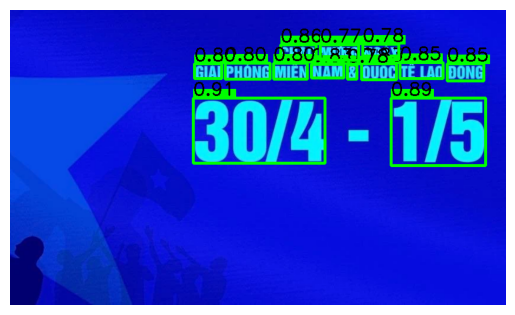

In [44]:
import requests
import cv2
import json
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Tải ảnh từ URL
url = 'https://image.dienthoaivui.com.vn/x,webp,q90/https://dashboard.dienthoaivui.com.vn/uploads/dashboard/editor_upload/bang-ron-chao-mung-30-4-va-1-5-13.jpg'
img_data = requests.get(url).content

# Lưu ảnh vào file cục bộ
with open('image.jpg', 'wb') as f:
    f.write(img_data)

# Đọc ảnh từ file cục bộ
image_path = 'image.jpg'

# Cài đặt mô hình và tải trọng số
model_path = 'drive/MyDrive/Study/AIO/Scene Text Recognition/models/yolov8/detec/train/weights/best.pt'
conf_thres = 0.75
model = YOLO(model_path)

# Dự đoán
results = model(image_path, verbose=False)

# Chuyển kết quả thành JSON
predictions = json.loads(results[0].to_json())
print(predictions[0])

# Vẽ bounding box trên ảnh
visualized_img = visualize_bbox(image_path, predictions, conf_thres)

# Hiển thị ảnh
%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()
